# TF Serving
This example shows how to load a Vision Transformer model (ViT) from Hugging Faces, store it to the local file system and afterwards use it to serve in a tensorflow model server.

Tutorial used from <https://huggingface.co/blog/tf-serving-vision>

In [1]:
# Imports
import os
from IPython.display import display

import tensorflow as tf
print("tensorflow", tf.__version__)

import transformers
print("transformers", transformers.__version__)

tensorflow 2.11.0
transformers 4.25.1


### Load a pretrained model
Let's first load a Vision Transformer model and save it

In [2]:
from transformers import TFViTForImageClassification

# the saved_model parameter is a flag to create a saved model version of the model
export_path = "vit_local"
ckpt = "google/vit-base-patch16-224"

model = TFViTForImageClassification.from_pretrained(ckpt)
model.save_pretrained(save_directory= export_path, saved_model=True)

All model checkpoint layers were used when initializing TFViTForImageClassification.

All the layers of TFViTForImageClassification were initialized from the model checkpoint at google/vit-base-patch16-224.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageClassification for predictions without further training.


INFO:tensorflow:Assets written to: vit_local\saved_model\1\assets


INFO:tensorflow:Assets written to: vit_local\saved_model\1\assets


In [3]:
# load and store preprocessing
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained(ckpt)
feature_extractor.save_pretrained(save_directory= export_path, saved_model=True)

['vit_local\\preprocessor_config.json']

In [4]:
# Check the model signature
!saved_model_cli show --dir {export_path}/saved_model/1 --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['pixel_values'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, -1, -1, -1)
      name: serving_default_pixel_values:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['logits'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1000)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


## Test local model

In [5]:
from transformers import ViTForImageClassification, ViTFeatureExtractor

# reload back again
model = ViTForImageClassification.from_pretrained(export_path, from_tf=True)
feature_extractor = ViTFeatureExtractor.from_pretrained(export_path, from_tf=True)

All TF 2.0 model weights were used when initializing ViTForImageClassification.

All the weights of ViTForImageClassification were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use ViTForImageClassification for predictions without further training.


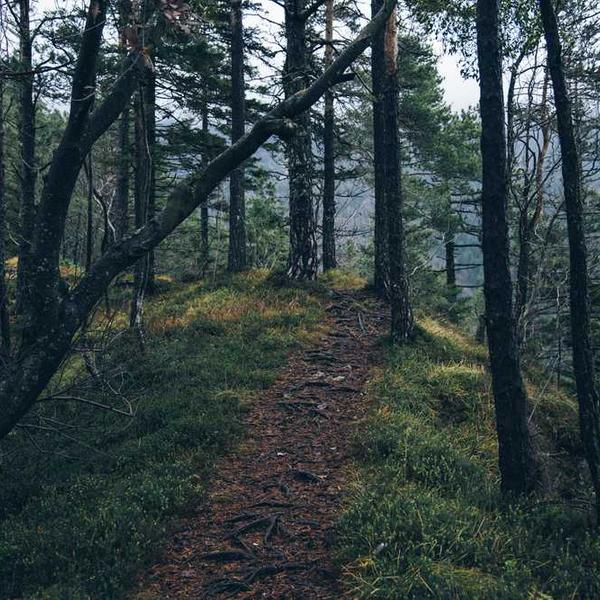

In [6]:
from PIL import Image
import requests

url= "https://picsum.photos/600/600"
image = Image.open(requests.get(url, stream=True).raw)
image

In [7]:
# local prediction
inputs = feature_extractor(image, return_tensors="pt")
pixel_values = inputs.pixel_values

outputs = model(pixel_values)
logits = outputs.logits

In [8]:
pixel_values

tensor([[[[ 0.1843,  0.5294, -0.4588,  ...,  0.2549,  0.3255,  0.2941],
          [-0.1059,  0.1216, -0.2157,  ...,  0.3098,  0.0431,  0.4196],
          [-0.2863,  0.3725,  0.2235,  ..., -0.2627, -0.1216,  0.6863],
          ...,
          [-0.8667, -0.9059, -0.8667,  ..., -0.7882, -0.8039, -0.8275],
          [-0.8745, -0.8667, -0.8353,  ..., -0.8196, -0.7412, -0.8039],
          [-0.8510, -0.8667, -0.8039,  ..., -0.8353, -0.7961, -0.8196]],

         [[ 0.2314,  0.5843, -0.3882,  ...,  0.3569,  0.4431,  0.4039],
          [-0.0667,  0.1843, -0.1451,  ...,  0.4196,  0.1608,  0.5216],
          [-0.2471,  0.4275,  0.2941,  ..., -0.1529, -0.0118,  0.7882],
          ...,
          [-0.7490, -0.7882, -0.7647,  ..., -0.6863, -0.6941, -0.7176],
          [-0.7569, -0.7490, -0.7333,  ..., -0.7176, -0.6392, -0.6941],
          [-0.7333, -0.7490, -0.7020,  ..., -0.7412, -0.6941, -0.7020]],

         [[ 0.4353,  0.7098, -0.2627,  ...,  0.4353,  0.4980,  0.4588],
          [ 0.1529,  0.3333, -

In [9]:

# take argmax on logits' last dimension
predicted_class_idx = logits.argmax(-1).item()
# turn into actual class name
print(model.config.id2label[predicted_class_idx])

lakeside, lakeshore


## Prepare server model

In [10]:
from transformers import TFViTForImageClassification, AutoFeatureExtractor

model = TFViTForImageClassification.from_pretrained(ckpt)

All model checkpoint layers were used when initializing TFViTForImageClassification.

All the layers of TFViTForImageClassification were initialized from the model checkpoint at google/vit-base-patch16-224.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageClassification for predictions without further training.


In [11]:
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained(ckpt)
print(feature_extractor)

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}



### Preprocessing

In [12]:
CONCRETE_INPUT = "pixel_values" # Which is what we investigated via the SavedModel CLI.
SIZE = feature_extractor.size['height'] # returned as dict of width and height, since both are equal us height for SIZE

In [13]:
def normalize_img(img, mean=feature_extractor.image_mean, std=feature_extractor.image_std):
    # Scale to the value range of [0, 1] first and then normalize.
    img = img / 255
    mean = tf.constant(mean)
    std = tf.constant(std)
    return (img - mean) / std

def preprocess(string_input):
    decoded_input = tf.io.decode_base64(string_input)
    decoded = tf.io.decode_jpeg(decoded_input, channels=3)
    resized = tf.image.resize(decoded, size=(SIZE, SIZE))
    normalized = normalize_img(resized)
    normalized = tf.transpose(
        normalized, (2, 0, 1)
    )  # Since HF models are channel-first.
    return normalized


@tf.function(input_signature=[tf.TensorSpec([None], tf.string)])
def preprocess_fn(string_input):
    decoded_images = tf.map_fn(
        preprocess, string_input, dtype=tf.float32, back_prop=False
    )
    return {CONCRETE_INPUT: decoded_images}

### Postprocessing

In [14]:
# 1) Pass the inputs through the preprocessing operations.
# 2) Pass the preprocessing inputs through the derived concrete function.
# 3) Post-process the outputs and return them in a nicely formatted dictionary.

def model_exporter(model: tf.keras.Model):
    m_call = tf.function(model.call).get_concrete_function(
        tf.TensorSpec(
            shape=[None, 3, SIZE, SIZE], dtype=tf.float32, name=CONCRETE_INPUT
        )
    )

    @tf.function(input_signature=[tf.TensorSpec([None], tf.string)])
    def serving_fn(string_input):
        labels = tf.constant(list(model.config.id2label.values()), dtype=tf.string)

        images = preprocess_fn(string_input)
        predictions = m_call(**images)

        indices = tf.argmax(predictions.logits, axis=1)
        pred_source = tf.gather(params=labels, indices=indices)
        probs = tf.nn.softmax(predictions.logits, axis=1)
        pred_confidence = tf.reduce_max(probs, axis=1)
        return {"label": pred_source, "confidence": pred_confidence}

    return serving_fn

In [15]:
# Export the model
export_path = "vit_serving"
VERSION = 1

tf.saved_model.save(
    model,
    os.path.join(export_path, str(VERSION)),
    signatures={"serving_default": model_exporter(model)},
)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))


Instructions for updating:
Use fn_output_signature instead


Instructions for updating:
Use fn_output_signature instead


INFO:tensorflow:Assets written to: vit_serving\1\assets


INFO:tensorflow:Assets written to: vit_serving\1\assets


In [16]:
# Check the model signature
!saved_model_cli show --dir {export_path}/1 --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['string_input'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: serving_default_string_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['confidence'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: StatefulPartitionedCall:0
  outputs['label'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: StatefulPartitionedCall:1
Method name is: tensorflow/serving/predict


## Test tensorflow/serving using REST API

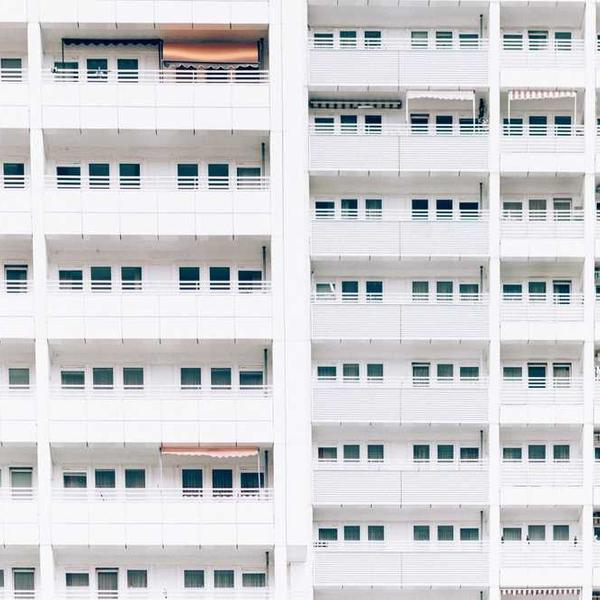

{'predictions': [{'confidence': 0.142312482, 'label': 'liner, ocean liner'}]}


In [25]:
import json
from io import BytesIO
from PIL import Image
import requests
import base64

url= "https://picsum.photos/600/600"
image = Image.open(requests.get(url, stream=True).raw)
display(image)

# convert to base64
buffer= BytesIO()
image.save(buffer, format="JPEG")
b64str= base64.urlsafe_b64encode(buffer.getvalue()).decode("utf-8")

# prepare data
data = json.dumps({"signature_name": "serving_default", "instances": [b64str]})
# print("Data: {} ... {}".format(data[:50], data[len(data) - 52 :]))

# prepare header
headers = {"content-type": "application/json"}

# send request
json_response = requests.post(
    "http://localhost:8501/v1/models/vit:predict", data=data, headers=headers
)

# print response
print(json.loads(json_response.text))